In [22]:
from sklearn.decomposition import PCA
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
from pymongo import MongoClient
import faiss
import matplotlib.pyplot as plt
from deepface import DeepFace
import pickle
import time

In [23]:
def get_db():
    return MongoClient("mongodb://localhost:27017/")['VectorBase']

def generate_embedding(image_path):
    return DeepFace.represent(img_path=image_path, model_name="Facenet512", enforce_detection=False)[0]['embedding']


def save_pca():
    pca = PCA(49)
    collection = get_db()['FaceNet512']
    vectors = np.zeros((collection.count_documents({}), 512), dtype=np.float32)

    for i, vector_doc in tqdm(enumerate(collection.find()), desc='Downloading embeddings from MongoDB'):
        vectors[i] = vector_doc['vector']

    pca.fit(vectors)

    with open('pca.pkl', 'wb') as file:
        pickle.dump(pca, file)

def load_pca():
    with open('pca.pkl', 'rb') as file:
        return pickle.load(file)

In [24]:
class Generator:
    def __init__(self):
        db = get_db()
        self.collection = db['FaceNet512']
        self.reduced_collection = db['FaceNet512_reduced']

        self.extensions = ['.jpg', '.png']

    def clear_collection(self):
        self.collection.delete_many({})

    def clear_reduced_collection(self):
        self.reduced_collection.delete_many({})

    def generate_vectors(self, directory: str = None, directories: list = None):
        image_file_paths = []

        if directories is None:
            directories = [directory]

        for directory in directories:
            for root, _, files in os.walk(directory):
                for file in files:
                    if any(file.endswith(ext) for ext in self.extensions):
                        file_path = os.path.join(root, file)
                        image_file_paths.append(file_path)

        for vector_id in tqdm(range(len(image_file_paths)), desc="Generating embeddings"):
            self.collection.insert_one({
                "path": image_file_paths[vector_id],
                "vector": generate_embedding(image_file_paths[vector_id])
            })

    def generate_reduced_vectors(self):
        vectors = np.zeros((self.collection.count_documents({}), 512), dtype=np.float32)
        paths = []

        for i, vector_doc in tqdm(enumerate(self.collection.find()), desc='Downloading embeddings from MongoDB'):
            vectors[i] = vector_doc['vector']
            paths.append(vector_doc['path'])

        pca = load_pca()
        vectors = pca.transform(vectors)

        for vector_id in tqdm(range(len(paths)), desc="Uploading reduced embeddings to MongoDB"):
            self.reduced_collection.insert_one({
                "path": paths[vector_id],
                "vector": vectors[vector_id].tolist()
            })

In [25]:
list_directories = ['./img_align_celeba/img_align_celeba', './custom'] # list of directories with image datasets

gen = Generator()
# gen.clear_collection()
gen.clear_reduced_collection()
# gen.generate_vectors(directories=list_directories)
save_pca()
gen.generate_reduced_vectors()

Uploading reduced embeddings to MongoDB: 100%|██████████| 202609/202609 [00:54<00:00, 3693.73it/s]


In [26]:
class SimilarSearch:
    def __init__(self, Index = faiss.IndexFlatL2):
        collection = get_db()['FaceNet512_reduced']
        self.pca = load_pca()
        self.vectors = np.zeros((collection.count_documents({}), 49), dtype=np.float32)
        self.paths = []
        
        for i, vector_doc in tqdm(enumerate(collection.find()), desc='Downloading embeddings from MongoDB'):
            self.vectors[i] = vector_doc['vector']
            self.paths.append(vector_doc['path'])

        self.index = Index(49)

        self.index.add(self.vectors)

    def find_most_similar(self, image_src, top_similar=10):
        embedding = self.pca.transform(np.array(generate_embedding(image_src)).reshape(1, -1))
        start_time = time.monotonic()
        scores, indices = self.index.search(embedding, top_similar)
        end_time = time.monotonic()
        print(f'Execution time of searching: {end_time - start_time} sec')
        top_paths = np.array(self.paths)[indices.flatten()]
        
        fig, axs = plt.subplots(1, top_similar + 1, figsize=(14,14))

        axs[0].imshow(np.asarray(Image.open(image_src)))
        axs[0].set_title(f'your image')
        axs[0].set_axis_off()

        for i in range(top_similar):
            axs[i + 1].imshow(np.asarray(Image.open(top_paths[i])))
            axs[i + 1].set_title(f'score: {int(scores[0][i])}')
            axs[i + 1].set_axis_off()
        fig.tight_layout(rect=[0.01, 0, 1, 1])

In [27]:
search_base = SimilarSearch(faiss.IndexFlatL2)

Execution time of searching: 0.014999999999986358 sec


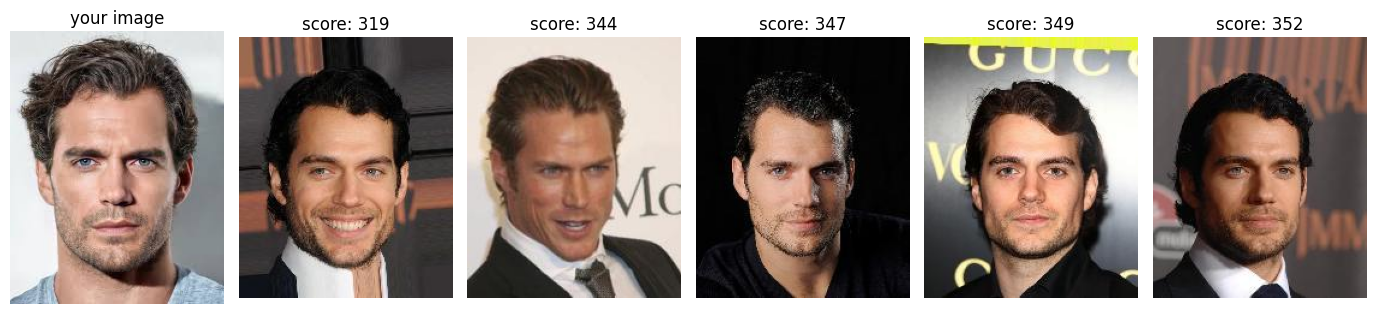

In [28]:
src = 'henry_cavil.jpg' # name of your image

search_base.find_most_similar(src, 5)